# Emcee notebook
15 November 2019

In this notebook, we use the emcee package instead of the built-in lenstronomy MCMC function to see if we still get the same strange diverging chains.

It seems to be working, at least if we just want to stick to modeling the lens, and keep the covariances small enough.

In [1]:
import matplotlib.pyplot as plt

Warm-up example:

In [2]:
import numpy as np
import emcee

# def log_prob(x, ivar):
#     return -0.5 * np.sum(ivar * x ** 2)

# ndim, nwalkers = 5, 100
# ivar = 1. / np.random.rand(ndim)
# p0 = np.random.randn(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[ivar])
# sampler.run_mcmc(p0, 10000);

def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

state = sampler.run_mcmc(p0, 100)

In [10]:
%%time
sampler.reset()
state2 = sampler.run_mcmc(state, 1000)

CPU times: user 876 ms, sys: 0 ns, total: 876 ms
Wall time: 870 ms


means = 0.3745401188473625 avg= 0.39769474182857056


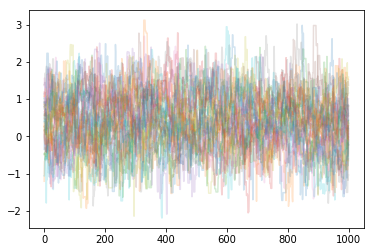

means = 0.9507143064099162 avg= 0.9460712835574914


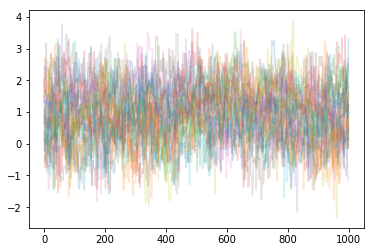

means = 0.7319939418114051 avg= 0.7315670544089972


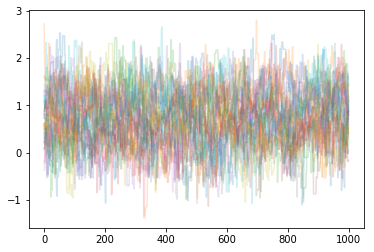

means = 0.5986584841970366 avg= 0.6036946156311476


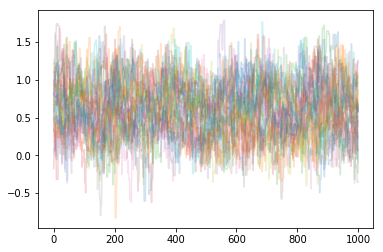

means = 0.15601864044243652 avg= 0.1568347565840449


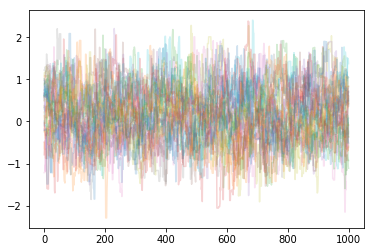

In [12]:
for i in range(ndim):
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i], alpha = .2)
        
    print('means =',means[i], 'avg=',np.mean(sampler.chain[:,:,i]))
    plt.show()

# Generate image

In [13]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cms
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import copy

In [14]:
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return m_msun/((rs_mpc**2.)*sigma_cr(zd,zs))

def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))


def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    ## takes in physical coordinates (Mpc), identifies the appropriate pixel number
    return (xi_to_x(xi,z))/pixsize + pixnum/2.

In [231]:
## REDSHIFTS #######################################################################################
Nit = 100 ##Number of different redshifts
zds = np.linspace(0.01,0.99,Nit)
####################################################################################################



## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.2)
beta_ras, beta_decs = [1.7],[0.3]#this is the source position on the source plane

n_sersic_source = 1.5

## SOURCE-CLUMP PROPERTIES #########################################################################
r_sersic_source_clumps = 1/3.
N_clump = 0
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1. ## This is how wide the scatter of the clumps over the smooth source

n_sersic_source_clumps = 1.5

####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 10.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.8)
gamma = 2.

center_lens_x, center_lens_y = 0.,0.
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 0 ##Number of perturbers
M = 1 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
# Perturbers are uniformly distributed within a disk of radius `disc_size * r_theta_lens`
r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M]) # will add pixel values in the next cell
ypixs = np.zeros([Nit,N,M]) #
####################################################################################################

## Reference image
Generate the reference image. Some of the parameters that go into this definition are used in later cells as well (in particular `kwargs_spep`).

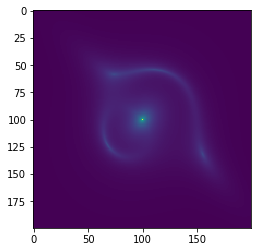

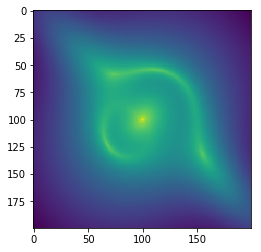

In [232]:
j = 19 # arbitrary choice (loop over redshifts)
k = 0 # also arbitrary choice (loop over statistics)

beta_ra, beta_dec = beta_ras[0], beta_decs[0]

xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)

m =1.0e7 # mass of interlopers
if j == 0:
    m = 0. # so that the first image will be pure (no interloper effect)
zs = 1.
zd = zds[j] # interloper redshift
rs = 0.001  # interloper scale radius r_s
A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE

kext = float(k_ext(N,m,A,zl,zs,pixsize))
rsang = float(rs_angle(zd,rs))
alphars = float(alpha_s(m,rs,zd,zs))

## Setting lens_model_list and redshift_list
lens_model_main = ['SPEP']
lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(N)]
redshift_main = [zl]
redshift_interlopers = [zd]+[zd for i in range(N)]
# (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
if zl >= zd:
    lens_model_list = lens_model_interlopers + lens_model_main
    redshift_list = redshift_interlopers + redshift_main
else:
    lens_model_list = lens_model_main + lens_model_interlopers
    redshift_list = redshift_main + redshift_interlopers


z_source = zs

lensModel_mp = LensModel(lens_model_list=lens_model_list,
                         z_source=z_source,
                         lens_redshift_list=redshift_list, 
                         multi_plane=True)

kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
               'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
kwargs_conv ={'kappa_ext': kext}

### NFW kwargs for the interlopers
kwargs_main_lens = [kwargs_spep]
kwargs_interlopers = [kwargs_conv] # (+ will append interlopers)
for i in range(N):
    center_nfw_x = xi_to_x(xs[i,k],zd)
    center_nfw_y = xi_to_x(ys[i,k],zd)

    kwargs_nfw = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_nfw_x, 'center_y': center_nfw_y}
    kwargs_interlopers.append(kwargs_nfw)

# (again, need to sort by redshift)
if zl >= zd:
    kwargs_lens = kwargs_interlopers + kwargs_main_lens
else:
    kwargs_lens = kwargs_main_lens + kwargs_interlopers

########################################################################
# set up the list of light models to be used #

# SOURCE light
source_light_model_list = ['SERSIC_ELLIPSE']
for i in range(N_clump):
    source_light_model_list.append('SERSIC')

lightModel_source = LightModel(light_model_list = source_light_model_list)

# LENS light
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list = lens_light_model_list)

# SOURCE light kwargs
kwargs_light_source = [{'amp': 1000., 'R_sersic': r_sersic_source, 'n_sersic': n_sersic_source, 
                      'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
for i in range(N_clump):
    kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source_clumps, 'n_sersic': n_sersic_source_clumps,
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})

# LENS light kwargs
kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                      'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

# evaluate surface brightness at a specific position #
#flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel correspon
kernel = psf.kernel_point_source

####################################################################################

# import the ImageModel class #

# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image); plt.show()
plt.imshow(np.log(image)); plt.show()

For now, we can ignore the noise effects, but here's how we'd compute it.

In [233]:
## Noisy Image #####################################################################
exp_time = 100  # exposure time to quantify the Poisson noise level (what units?)
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson
# plt.imshow(image_noisy); plt.show()
# plt.imshow(np.log(image_noisy)); plt.show()

## Define macro model

In [234]:
lens_model_macro_list = ['SPEP']
lens_model_macro = LensModel(lens_model_list=lens_model_macro_list,
                         z_source=z_source, multi_plane=False)
image_model_macro = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens_model_macro,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)

def gen_image_macro(kwargs_lens_model): # rewrite the cell above as a function of the lens kwargs
    image = image_model_macro.image(kwargs_lens=kwargs_lens_model, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)
    
    return image

In [235]:
def error(image1, image2):
    assert(image1.shape == image2.shape)
    return np.sum((image1 - image2)**2)

In [236]:
def args_to_img(args):
    center_x, center_y, e1, e2, gamma, theta_E = args
    image_macro = gen_image_macro([{'center_x':center_x,
                                   'center_y':center_y,
                                   'e1':e1,
                                   'e2':e2,
                                   'gamma':gamma,
                                   'theta_E':theta_E}])
    return image_macro

def log_prob(args):
    err = error(image, args_to_img(args))
    return -err

In [237]:
keys = ['center_x', 'center_y', 'e1', 'e2', 'gamma', 'theta_E']

ndim = len(keys)

means = [kwargs_spep[k] for k in keys]

cov = 0.5 - 0.001 * np.random.rand(ndim**2).reshape((ndim,ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

for i in range(ndim):
    for j in range(ndim):
        ratio = .005
        if keys[i] == 'e1' or keys[i] == 'e2':
            ratio *= .3
        if keys[j] == 'e1' or keys[j] == 'e2':
            ratio *= .3
        
        cov[i,j] *= ratio

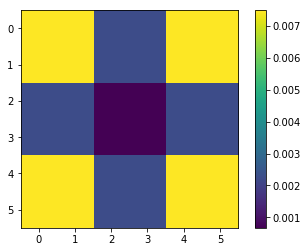

In [238]:
plt.imshow(cov); plt.colorbar()

In [239]:
nwalkers = 40
p0 = means + np.diag(cov) * (np.random.rand(nwalkers, ndim)-.5)

In [240]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[])

In [241]:
%%time
state = sampler.run_mcmc(p0, 100)

CPU times: user 45.1 s, sys: 0 ns, total: 45.1 s
Wall time: 45.1 s


In [130]:
%%time
sampler.reset()
state2 = sampler.run_mcmc(state, 100)

CPU times: user 51.1 s, sys: 0 ns, total: 51.1 s
Wall time: 51.1 s


In [137]:
%%time
sampler.reset()
state3 = sampler.run_mcmc(state2, 500)

CPU times: user 4min 45s, sys: 1min 13s, total: 5min 59s
Wall time: 5min 59s


key center_x


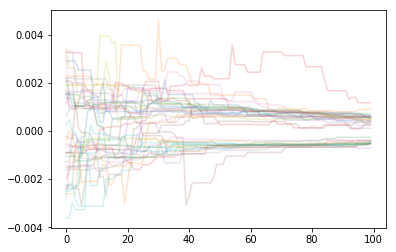

key center_y


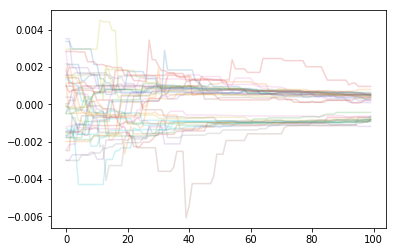

key e1


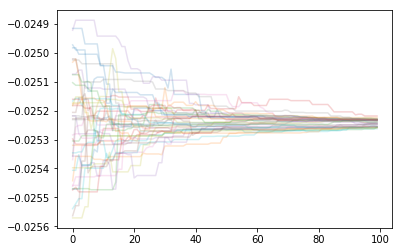

key e2


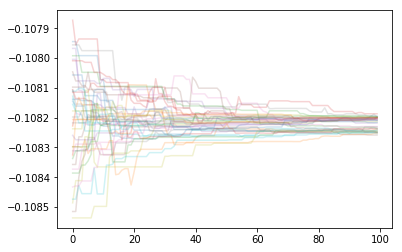

key gamma


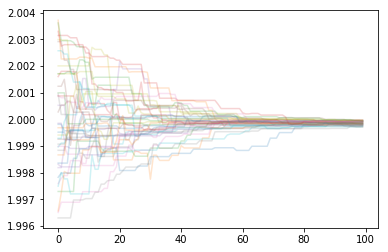

key theta_E


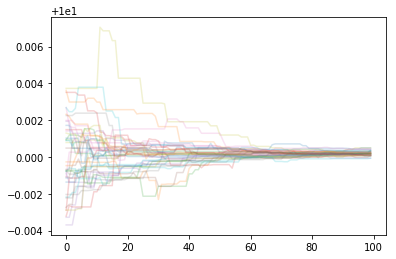

In [242]:
for i, key in enumerate(keys):
    print('key', key)
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i], alpha = .2)
    plt.show()

In [243]:
sampler.chain.shape

(40, 100, 6)

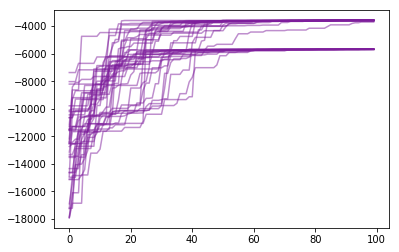

In [244]:
for j in range(nwalkers):
    plt.plot(sampler.lnprobability[j,:], alpha=.5, color='xkcd:purple')
    #plt.show()

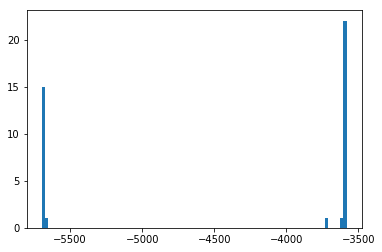

In [245]:
plt.hist(sampler.lnprobability[:,-1],bins=100)
plt.show()

In [248]:
# was -800, -50 or so when using 1 interloper but modelling to macro model

In [249]:
sampler.chain.shape

(40, 100, 6)

before


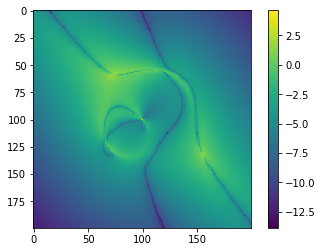

after


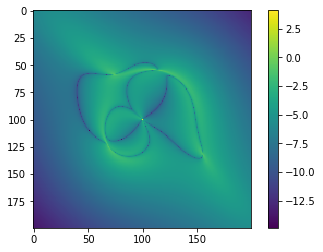

before


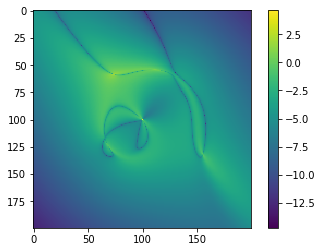

after


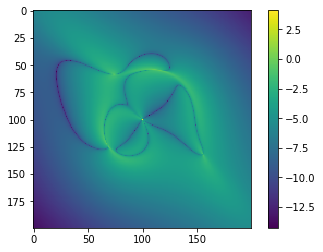

In [253]:
for j in range(nwalkers)[:2]:
#     print('before')
#     plt.imshow(args_to_img(sampler.chain[j,0,:])); plt.colorbar(); plt.show()
#     print('after')
#     plt.imshow(args_to_img(sampler.chain[j,-1,:])); plt.colorbar(); plt.show()
    print('before')
    plt.imshow(np.log(abs(args_to_img(sampler.chain[j,0,:])-image))); plt.colorbar(); plt.show()
    print('after')
    plt.imshow(np.log(abs(args_to_img(sampler.chain[j,-1,:])-image))); plt.colorbar(); plt.show()